In [89]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import config as cfg
import os
import pandas as pd
from utils import get_overview, open_gz, filter_district
import geopandas as gpd

In [99]:
geometria_dir = cfg.GEOMETRIA_DATA
personas_dir = cfg.PERSONAS_DATA
viajes_dir = cfg.VIAJES_DATA
zonificacion_dir = cfg.ZONIFICACION_DATA

In [100]:
rent_data = gpd.read_file('/Users/caro/Desktop/thesis_project/segregation_indices/data/geometries_and_rent.geojson') # rent data to add to the viajes data to find income per district
rent_data = rent_data[rent_data['Indicadores de renta media y mediana']=='Renta bruta media por hogar'] # filtering variable of interest
viajes = open_gz(viajes_dir / 'basicos_distritos_viajes_202406', [7, 8]) # substracting all trips in all districts of Spain during my weekend of interest (June 8th, 9th) as a list
viajes_combined = pd.concat(viajes, ignore_index=True) # concatenating both days of interest


/Users/caro/Desktop/thesis_project/segregation_indices/utils.py:33: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, compression='gzip', sep='|') # Read the compressed CSV file
/Users/caro/Desktop/thesis_project/segregation_indices/utils.py:33: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, compression='gzip', sep='|') # Read the compressed CSV file


In [101]:
madrid = filter_district(viajes_combined, '28079')
#NOTE: The residence of the users in the MITMA data is not by district, but by province. 
# This could be a problem as I am trying to understand how people from different districts move. 
# As a solution, I could filter to only use ‘origen’ == casa or ‘destino’==casa in the districts of Madrid. 
# This way, I could make sure that I am taking a look at those records of people who actually live in a specific district in Madrid.
# The problem is that the mobility would be very limited to those trips either coming from or going home.
filtered_df = madrid.loc[(madrid['actividad_origen'] == 'casa')]

## Assortativity Matrix

### 1. Adding income data per district to the mobility data, to later calculate deciles and build assortativity matrix

In [107]:
filtered_df['origen'] = filtered_df['origen'].str.extract('(\d+)') # Extract only the numeric part

# Convert both columns to the same type (string, for instance)
rent_data['ID'] = rent_data['ID'].astype(str)
filtered_df['origen'] = filtered_df['origen'].astype(str)

# Merge the two DataFrames based on the corresponding columns
viajes_with_income = pd.merge(
    filtered_df,
    rent_data[['ID', 'Total']],  # Select only the 'ID' and 'Total' columns (Total is the income)
    left_on='origen',  # The cleaned 'origen' from viajes DataFrame
    right_on='ID',  # The 'ID' from gdf
    how='left'  # Perform a left join to keep all rows from viajes
)

# Rename 'Total' to 'income'
viajes_with_income.rename(columns={'Total': 'income'}, inplace=True)


/var/folders/5y/mx06x73d0yb7mfb57y7lb2nh0000gn/T/ipykernel_66051/3686206649.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['origen'] = filtered_df['origen'].str.extract('(\d+)') # Extract only the numeric part
/var/folders/5y/mx06x73d0yb7mfb57y7lb2nh0000gn/T/ipykernel_66051/3686206649.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['origen'] = filtered_df['origen'].astype(str)


### 2. Divide data into income deciles D for each SE class - for each origin and destination, I add the income decile 

In [108]:
rent_data['income_decile'] = pd.qcut(rent_data['Total'], 10, labels=False)

viajes_with_income = pd.merge(viajes_with_income, rent_data[['ID', 'income_decile']], 
                              left_on='origen', right_on='ID', how='left', suffixes=('', '_origin'))

viajes_with_income = pd.merge(viajes_with_income, rent_data[['ID', 'income_decile']], 
                              left_on='destino', right_on='ID', how='left', suffixes=('', '_dest'))

viajes_with_income.drop(columns=['residencia', 'estudio_origen_posible', 'estudio_origen_posible', 'ID', 'ID_origin', 'ID_dest'], inplace=True)

In [109]:
viajes_with_income

,fecha,periodo,origen,destino,distancia,actividad_origen,actividad_destino,estudio_destino_posible,renta,edad,sexo,viajes,viajes_km,income,income_decile,income_decile_dest
0,20240608,0,2807901,2807901,0.5-2,casa,frecuente,no,>15,0-25,mujer,25.354,17.873,49.775,4,4
1,20240608,0,2807901,2807901,0.5-2,casa,frecuente,no,>15,0-25,hombre,12.967,8.552,49.775,4,4
2,20240608,1,2807901,2807901,0.5-2,casa,frecuente,no,>15,0-25,mujer,10.866,11.263,49.775,4,4
3,20240608,1,2807901,2807901,0.5-2,casa,frecuente,no,>15,0-25,hombre,6.484,7.671,49.775,4,4
4,20240608,2,2807901,2807901,0.5-2,casa,frecuente,no,>15,0-25,mujer,14.488,9.014,49.775,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130132,20240609,19,2807921,2807921,2-10,casa,trabajo_estudio,no,>15,65-100,hombre,1.864,4.062,66.506,6,6
130133,20240609,20,2807921,2807921,2-10,casa,trabajo_estudio,no,>15,65-100,mujer,6.310,14.586,66.506,6,6
130134,20240609,21,2807921,2807921,2-10,casa,trabajo_estudio,no,>15,65-100,mujer,6.310,14.010,66.506,6,6
130135,20240609,21,2807921,2807921,2-10,casa,trabajo_estudio,no,>15,65-100,hombre,1.864,4.096,66.506,6,6


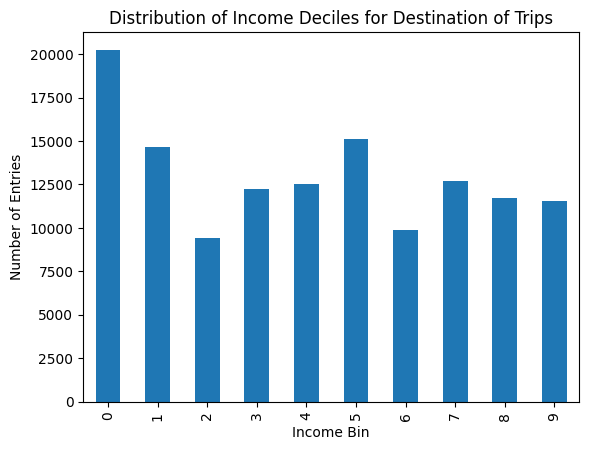

In [111]:
bin_counts = viajes_with_income['income_decile'].value_counts().sort_index()
bin_counts.plot(kind='bar')

plt.xlabel('Income Bin')
plt.ylabel('Number of Entries')
plt.title('Distribution of Income Deciles for Destination of Trips')

plt.show()


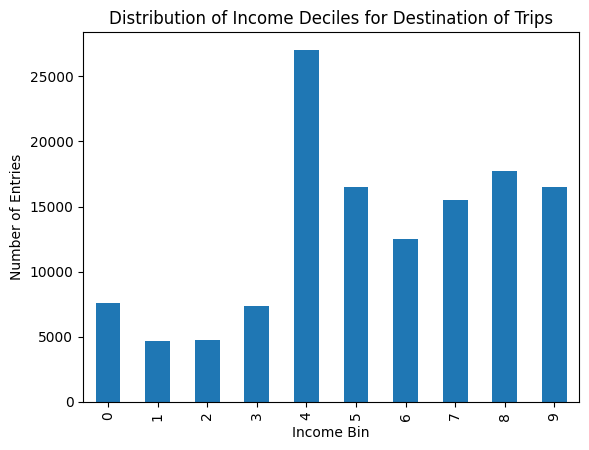

In [113]:
bin_counts = viajes_with_income['income_decile_dest'].value_counts().sort_index()
bin_counts.plot(kind='bar')

plt.xlabel('Income Bin')
plt.ylabel('Number of Entries')
plt.title('Distribution of Income Deciles for Destination of Trips')

plt.show()

### 3. For each decile and income from the mobility data (<10, 10-15, >15), count the number of trips between each origin-destination pair (ensure that this approach is correct)

In [149]:
# Group by origin and destination deciles and count the trips
trip_counts_by_decile = viajes_with_income.groupby(['renta', 'income_decile', 'income_decile_dest']).size().reset_index(name='trip_count')
districts = rent_data['ID'].unique()

### Build general matrix

In [128]:
# Assume districts is a list of the district names or IDs in Madrid
N = len(viajes_with_income['income_decile'].unique())  # Number of districts
A = np.zeros((N, N))  # Initialize an N x N matrix

In [136]:
assortativity_matrix = trip_counts_by_decile.pivot(index='income_decile', columns='income_decile_dest', values='trip_count').fillna(0)
assortativity_matrix_normalized = assortativity_matrix.div(assortativity_matrix.sum(axis=1), axis=0)

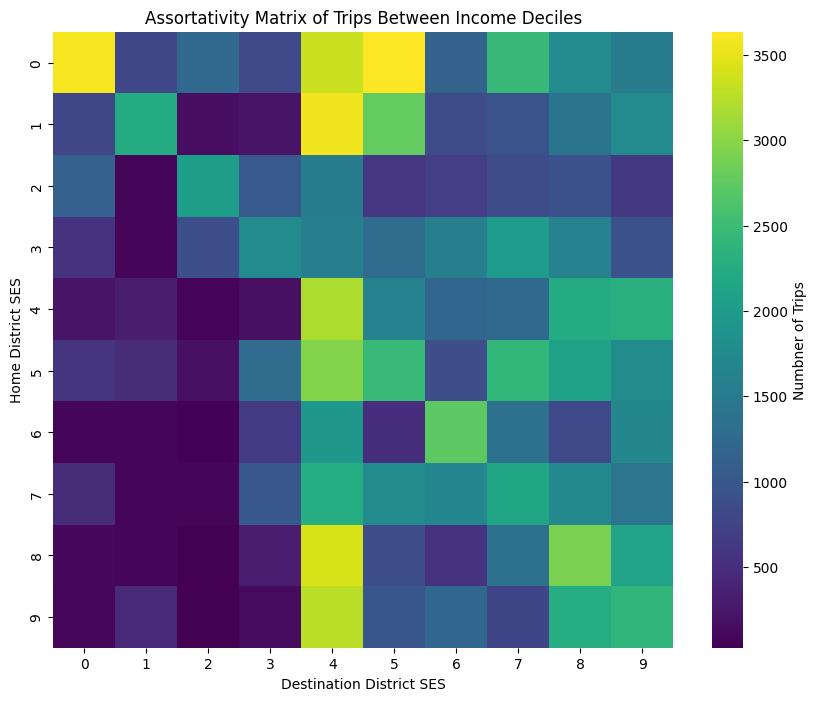

In [144]:
plt.figure(figsize=(10, 8))
sns.heatmap(assortativity_matrix, annot=False, cmap='viridis', cbar_kws={'label': 'Numbner of Trips'}, fmt=".2f")
plt.title('Assortativity Matrix of Trips Between Income Deciles')
plt.xlabel('Destination District SES')
plt.ylabel('Home District SES')
plt.show()

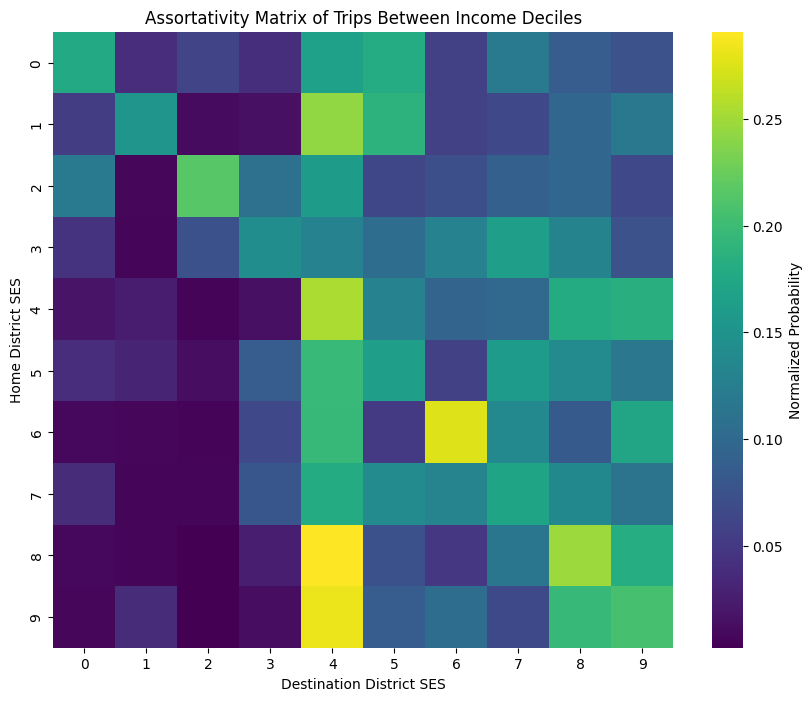

In [141]:
plt.figure(figsize=(10, 8))
sns.heatmap(assortativity_matrix_normalized, annot=False, cmap='viridis', cbar_kws={'label': 'Normalized Probability'}, fmt=".2f")
plt.title('Normalized Assortativity Matrix of Trips Between Income Deciles')
plt.xlabel('Destination District SES')
plt.ylabel('Home District SES')
plt.show()


In [148]:
for i in range(5):
    print(i, trip_counts_by_decile[trip_counts_by_decile['income_decile']==i].trip_count.mean())

0 2024.2
1 1467.4
2 944.4
3 1223.9
4 1255.3


### Build matrix per income bracket (low-middle-high)

In [168]:
middle = trip_counts_by_decile[trip_counts_by_decile['renta']=='10-15']
high = trip_counts_by_decile[trip_counts_by_decile['renta']=='>15']

In [172]:
assortativity_matrix_middle = middle.pivot(index='income_decile', columns='income_decile_dest', values='trip_count').fillna(0)
assortativity_matrix_middle_normalized = assortativity_matrix_middle.div(assortativity_matrix_middle.sum(axis=1), axis=0)

assortativity_matrix_high = high.pivot(index='income_decile', columns='income_decile_dest', values='trip_count').fillna(0)
assortativity_matrix_high_normalized = assortativity_matrix_high.div(assortativity_matrix_high.sum(axis=1), axis=0)

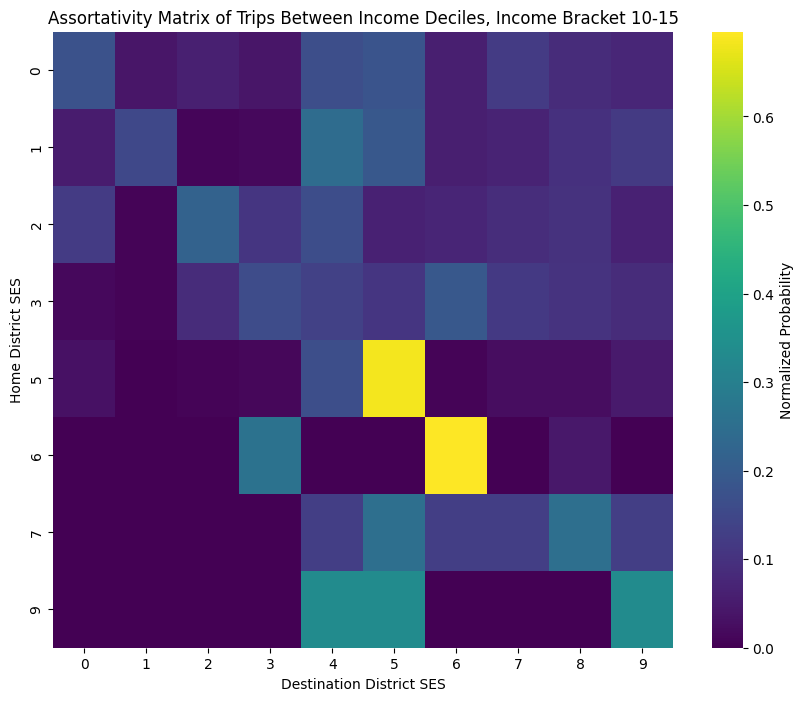

In [173]:
plt.figure(figsize=(10, 8))
sns.heatmap(assortativity_matrix_middle_normalized, annot=False, cmap='viridis', cbar_kws={'label': 'Normalized Probability'}, fmt=".2f")
plt.title('Assortativity Matrix of Trips Between Income Deciles, Income Bracket 10-15')
plt.xlabel('Destination District SES')
plt.ylabel('Home District SES')
plt.show()

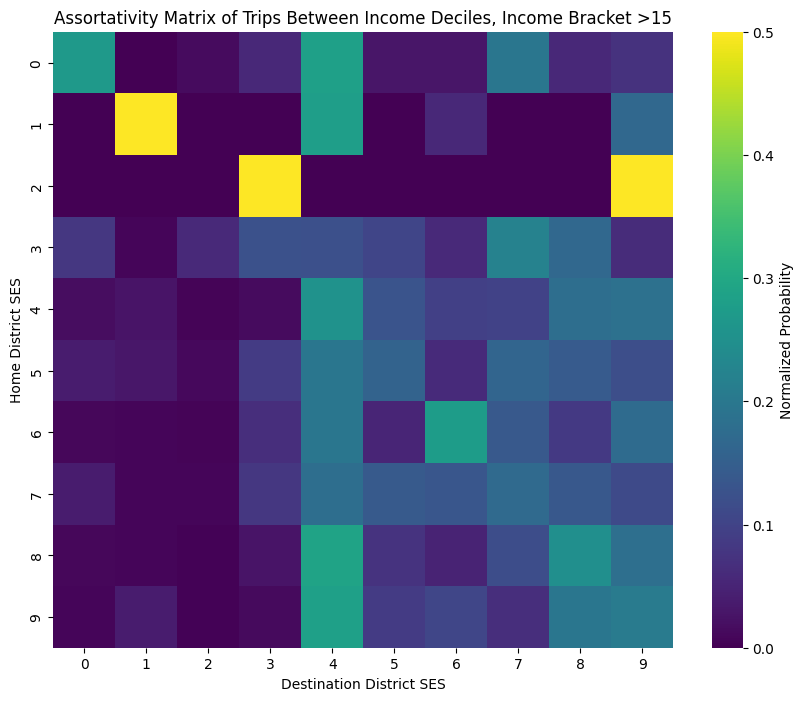

In [174]:
plt.figure(figsize=(10, 8))
sns.heatmap(assortativity_matrix_high_normalized, annot=False, cmap='viridis', cbar_kws={'label': 'Normalized Probability'}, fmt=".2f")
plt.title('Assortativity Matrix of Trips Between Income Deciles, Income Bracket >15')
plt.xlabel('Destination District SES')
plt.ylabel('Home District SES')
plt.show()